# Olist Brazil Ecommerce data collection and pre-processing

## Table of Contents
  - [Introduction](#introduction)
  - [Goal](#goal)
  - [EDA](#eda)
    - [Loading the data and checking it's shape](#loading-the-data-and-checking-it's-shape)
    - [1. Orders dataset](#1.-orders-dataset)
    - [2. Order items dataset](#2.-order-items-dataset)
    - [3. Order payments dataset](#3.-order-payments-dataset)
    - [4. Order reviews dataset](#4.-order-reviews-dataset)
    - [5. Products dataset](#5.-products-dataset)
    - [6. Sellers dataset](#6.-sellers-dataset)
    - [7. Customers dataset](#7.-customers-dataset)
    - [8. Product category name translation dataset](#8.-product-category-name-translation-dataset)
    - [9. Geolocation dataset](#9.-geolocation-dataset)
  - [Merging the dataset](#merging-the-dataset)
    - [Dropping irrelevant columns](#dropping-irrelevant-columns)
    - [Saving the cleaned and combined dataset](#saving-the-cleaned-and-combined-dataset)


## Introduction

[Olist](https://olist.com/) is an online marketplace in Brazil. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners.

The dataset is taken from [Kaggle](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce) and contains information about 100K oreders from 2016 to 2018 made at multiple marketplaces in Brazil. This is real commercial data that has been anonymized. 

## Goal

In this notebook, we will do EDA (Exploratory Data Analysis) on the dataset provided, and clean the data such that we can answer the following questions:

- What was the sales performance of Olist in 2017-2018?
- What does the data tell us about customer satisafaction? Are there any specific areas that we should pay attention to?
- What is the relationship between seller location and buyer location?

Once the dataset is cleaned and combined, we will create dashboards in Tableau that will help answer the above questions.


## EDA

The schema for the Olist database is as follows:

![Olist Schema](Olist_schema.png)

We will inspect each of these tables and see what data is relevant for our questions. Let's start by importing the relevant libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Loading the data and checking it's shape

In [2]:
# Load the dataset
# This is the core dataset. From each order you might find all other information.
df_orders = pd.read_csv("../data/raw/olist_orders_dataset.csv")

# This dataset includes data about the items purchased within each order.
df_order_items = pd.read_csv("../data/raw/olist_order_items_dataset.csv")

# This dataset includes data about the orders payment options.
df_order_payments = pd.read_csv("../data/raw/olist_order_payments_dataset.csv")

# This dataset includes data about the reviews made by the customers.
# After a customer purchases the product from Olist Store a seller gets notified to fulfill that order.
# Once the customer receives the product, or the estimated delivery date is due,
# the customer gets a satisfaction survey by email where he can give a note for the purchase experience
# and write down some comments.
df_order_reviews = pd.read_csv("../data/raw/olist_order_reviews_dataset.csv")

# This dataset includes data about the products sold by Olist.
df_products = pd.read_csv("../data/raw/olist_products_dataset.csv")

# This dataset includes data about the sellers that fulfilled orders made at Olist.
# Use it to find the seller location and to identify which seller fulfilled each product.
df_sellers = pd.read_csv("../data/raw/olist_sellers_dataset.csv")

# This dataset has information Brazilian zip codes and its lat/lng coordinates.
# Use it to plot maps and find distances between sellers and customers.
df_geolocation = pd.read_csv("../data/raw/olist_geolocation_dataset.csv")

# This dataset has information about the customer and its location.
# Use it to identify unique customers in the orders dataset and to find the orders delivery location.
# At our system each order is assigned to a unique customer_id. This means that the same customer will get different ids for different orders.
# The purpose of having a customer_unique_id on the dataset is to allow you to identify customers
# that made repurchases at the store. Otherwise you would find that each order had a different customer associated with.
df_customers = pd.read_csv("../data/raw/olist_customers_dataset.csv")

df_name_translation = pd.read_csv("../data/raw/product_category_name_translation.csv")

In [3]:
dfs = {"Orders": df_orders,
       "Order_items": df_order_items,
       "Order_Payments": df_order_payments,
       "Order_reviews": df_order_reviews,
       "Products": df_products,
       "Sellers": df_sellers,
       "Geolocation": df_geolocation,
       "Customers": df_customers,
       "Name_Translation": df_name_translation}

In [4]:
for key, value in dfs.items():
    print(f'The {key} dataset has {value.shape[0]} rows and {value.shape[1]} columns')

The Orders dataset has 99441 rows and 8 columns
The Order_items dataset has 112650 rows and 7 columns
The Order_Payments dataset has 103886 rows and 5 columns
The Order_reviews dataset has 99224 rows and 7 columns
The Products dataset has 32951 rows and 9 columns
The Sellers dataset has 3095 rows and 4 columns
The Geolocation dataset has 1000163 rows and 5 columns
The Customers dataset has 99441 rows and 5 columns
The Name_Translation dataset has 71 rows and 2 columns


We will define a function to plot the distribution of any column of interest.

In [5]:
def plotDistributionBar(df, columnName, top_n = 0):
    """
    This function will create a bar chart to show the distribution of the values in a column.

    Input Parameters:
    df:  DataFrame that contains the column.
    columnName: Column that we want to create the bar chart for.
    top_n: If you only want to plot the top n highest occuring elements.

    Output:
    Prints a bar chart that shows the distribution of the values of a column.

    Sample usage:
    plotDistributionBar(df_order_payments,'payment_type', 10)
    """
    percentages_all = round(df[columnName].value_counts(normalize=True)*100, 2)
    percentages = {}
    if top_n == 0:
        percentages = percentages_all
    else:
        if top_n < len(percentages_all) and top_n > 0:
            percentages = percentages_all[:top_n]

    plt.figure()
    if len(percentages_all) > 10:
        plt.figure(figsize=(15,5))
    graph = plt.bar(percentages.index, percentages.values)
    plt.title(f"Distribution of {columnName} in the dataset")
    plt.xticks(rotation=45)
    if len(percentages_all) > 10:
        plt.xticks(rotation=90)
    for p in graph:
        height=p.get_height()
        plt.annotate( "{}%".format(height),(p.get_x() + p.get_width()/2, height+.05),ha="center",va="bottom",fontsize=9)
    plt.show()

### 1. Orders dataset

In [6]:
df_orders.sample()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
40511,523d5e9ab692bee9c8dfd7063351f696,f0d9c201d2ab5c9467693e46b2c3d40c,delivered,2018-05-20 01:15:58,2018-05-20 08:17:30,2018-05-21 11:29:00,2018-05-22 16:48:44,2018-06-01 00:00:00


In [7]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


We can see that dates have type `object`, let's change it to datetime

In [8]:
df_orders['order_purchase_timestamp'] = df_orders['order_purchase_timestamp'].astype('datetime64[ns]')
df_orders['order_approved_at'] = df_orders['order_approved_at'].astype('datetime64[ns]')
df_orders['order_delivered_carrier_date'] = df_orders['order_delivered_carrier_date'].astype('datetime64[ns]')
df_orders['order_delivered_customer_date'] = df_orders['order_delivered_customer_date'].astype('datetime64[ns]')
df_orders['order_estimated_delivery_date'] = df_orders['order_estimated_delivery_date'].astype('datetime64[ns]')

In [9]:
# confirming that the date types have been fixed
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [10]:
#checking the null values
df_orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [11]:
df_orders.isnull().sum() / len(df_orders.index) * 100

order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.160899
order_delivered_carrier_date     1.793023
order_delivered_customer_date    2.981668
order_estimated_delivery_date    0.000000
dtype: float64

- 0.16% of the values are missing for `order_approved_at`.
- 1.79% of the values are missing for `order_delivered_carrier_date`.
- 2.98% of the values are missing for `order_delivered_customer_date`.

`order_approved_at` - we will drop the column as it is not useful for any of the questions we want to answer.

Let's check how many null values are present for orders whose status says 'delivered'

In [12]:
df_orders_delivered = df_orders.loc[df_orders['order_status'] == "delivered"]
df_orders_delivered.isna().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

There are 2 rows that have `order_status` as 'delivered' and `order_delivered_carrier_date` is null

And 8 rows where the `order_status` is 'delivered' and `order_delivered_customer_date` is null

These are very few number of rows and we can drop them if necessary. For now, we will leave them as is since we are not planning to build any ML models on them.

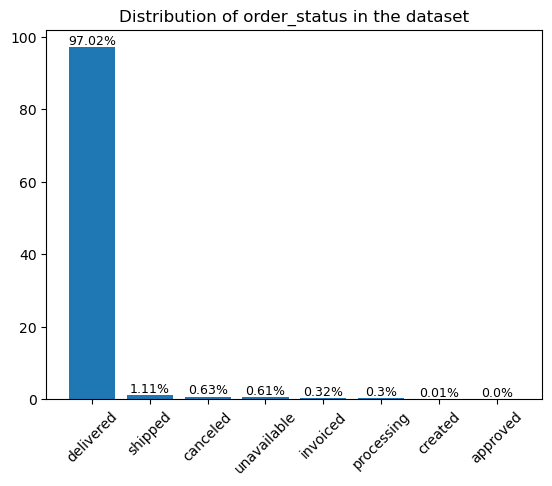

In [13]:
plotDistributionBar(df_orders,'order_status')

We have a total of eight order status. Our data has 97% of orders that were delivered. Only 0.63% of orders were cancelled. There are diferent order status that specify at which stage our order is.

We want to understand if there is any relationship with missing values and the order status. We will filter the rows with missing values and check what is the status of that order.

In [14]:
#checking the status where all the values are missing
df_orders.loc[df_orders['order_delivered_customer_date'].isnull() & \
           df_orders['order_delivered_carrier_date'].isnull() & \
           df_orders['order_approved_at'].isnull() ]['order_status'].value_counts()

order_status
canceled    141
created       5
Name: count, dtype: int64

Since 'canceled' orders make up only 0.63% of the dataset and 'created' orders are only 0.01% of the dataset, we will not worry about imputing the null values here, we can delete the rows if we decide to run ML algorithms on this dataset.

In [15]:
#checking duplicates across rows
df_orders.duplicated().sum()

0

In [16]:
#checking duplicates across columns
df_orders.columns.has_duplicates

False

In [17]:
# checking unique values for order_id
df_orders['order_id'].nunique()

99441

#### Quick findings:

- Orders dataset has information about the orders. Each order contains a customer id, order status, purchase timestamp and actual and estimated delivery information.
- We have a total of 99441 unique orders which is the primary key for this table.  
- We fixed the data type of 5 fields to be datetime instead of object.
- There are no duplicates across rows or columns.
- There are null values in 3 fields - `order_approved_at`, `order_delivered_carrier_date`, and `order_delivered_customer_date` but the percentage is low, so we will leave the nulls as is for now.

### 2. Order items dataset

In [18]:
df_order_items.sample(5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
96781,db9cf376e67dbdfc53109dce1354745b,1,630822139240c0cff5dc0b45a61961fb,79ebd9a61bac3eaf882805ed4ecfa12a,2018-08-16 15:30:12,129.9,40.10
37062,54220fcc516cabe9ec84b210c0765ef2,1,1166bc797ddf5fb009c376d133f61204,5cbbd5a299cab112b7bf23862255e43e,2017-11-30 20:13:16,59.2,17.98
33263,4b661d524b6f0788746514fb6f7ad3fa,1,431d674f9a4fbd0957ecf6ba3fcb6899,53243585a1d6dc2643021fd1853d8905,2017-12-01 16:11:09,235.9,13.90
70094,9ff266389e4ad0e51b289d25547ce0d2,1,84676380ed30810651646aee76522f90,7722b1df1b0e383e000397b2c11e3e19,2017-06-23 20:43:04,29.9,8.72
100438,e3ba5747e5730389e76a7d30694beeff,1,2a209ce7ce3ea3a21cc0b4c36495e9df,d91fb3b7d041e83b64a00a3edfb37e4f,2018-05-27 21:15:52,26.0,18.23


In [19]:
df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


Fix the data type of `shipping_limit_date`

In [20]:
df_order_items['shipping_limit_date'] = df_order_items['shipping_limit_date'].astype('datetime64[ns]')

In [21]:
df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


In [22]:
df_order_items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [23]:
df_order_items.duplicated().sum()

0

In [24]:
df_order_items.columns.has_duplicates

False

In [25]:
#checking the unique values in column order_id and order_item_id
df_order_items['order_id'].nunique()

98666

In [26]:
df_order_items['order_item_id'].nunique()

21

In [27]:
df_order_items['order_item_id'].value_counts()

order_item_id
1     98666
2      9803
3      2287
4       965
5       460
6       256
7        58
8        36
9        28
10       25
11       17
12       13
13        8
14        7
15        5
16        3
17        3
18        3
19        3
20        3
21        1
Name: count, dtype: int64

`order_item_id` seems to be the number of items in one order

In [28]:
df_order_items.loc[(df_order_items['order_item_id'] == 21)]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
57317,8272b63d03f5f79c56e9e4120aec44ef,21,79ce45dbc2ea29b22b5a261bbb7b7ee7,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,7.8,6.57


In [29]:
df_orders.loc[df_orders['order_id'] == '8272b63d03f5f79c56e9e4120aec44ef']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
88849,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28


In [30]:
99441 - 98666

775

#### Quick findings:

- Order item dataset has information about order item. It tells us about number of items in each order, shipping limit and freight value
- We have a total of 98666 order ids which is less than 99441.
- There are no duplicates across rows or columns.
- There are no null values.

### 3. Order payments dataset

In [31]:
df_order_payments.sample(5)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
2790,ffa4b16322a614306db6981043a52056,1,boleto,1,84.57
77026,b1724ab0a0aacf874471b620049dd38a,1,credit_card,1,42.17
25391,b955e1ecda001d15a6f9a0279d06ae5d,1,credit_card,2,140.13
62911,c67d722c949fca41de36455344293ed9,1,credit_card,4,124.43
45912,79c697a71c6bfb37a4c83d238e695404,3,voucher,1,9.71


In [32]:
df_order_payments['payment_type'].value_counts(normalize=True)*100

payment_type
credit_card    73.922376
boleto         19.043952
voucher         5.558978
debit_card      1.471806
not_defined     0.002888
Name: proportion, dtype: float64

In [33]:
df_order_payments.isna().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [34]:
df_order_payments.duplicated().sum()

0

In [35]:
df_order_payments.columns.has_duplicates

False

In [36]:
df_order_payments['order_id'].nunique()

99440

In [37]:
df_order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


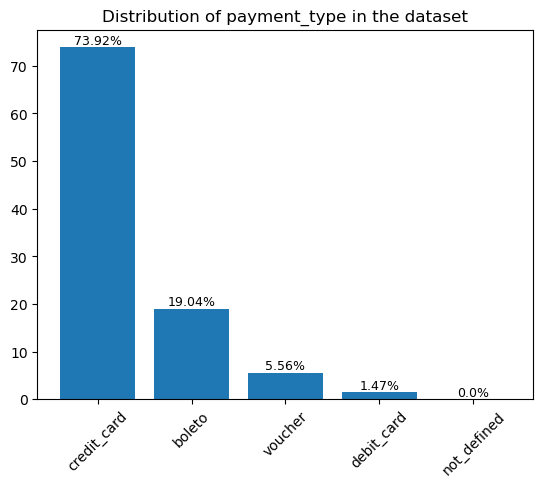

In [38]:
plotDistributionBar(df_order_payments,'payment_type')

#### Quick findings:

- Payments dataset has information about the way customer made payment for each order.
- We have payment information for 99440 unique order ids.
- This dataset has three columns of object datatype and two column with numeric datatype.
- There are no duplicates across rows or columns.
- There are no null values.
- `order_id` is the foreign key in this table.

### 4. Order reviews dataset

In [39]:
df_order_reviews.sample(5)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
43482,dc379c0831c4ecc16b70b7ba738cb964,924749e077350dcf416cfeaee379a61d,5,NaN,NaN,2017-12-23 00:00:00,2017-12-24 01:17:51
85352,5885bb9a2bb64050c8340f23b33bc90f,5cc52573e9c54f9546ad4e8fa7183c69,1,NaN,as mercaadorias deveriam ser entregues em uma ...,2017-09-12 00:00:00,2017-09-21 22:31:18
86502,4354165e73d5e0e3780e275770ab19e5,03789728a4b9475c05f6fe33ced95ccd,5,NaN,NaN,2018-03-22 00:00:00,2018-03-26 18:30:05
2935,f132f4e17a6a708ec6c4bf2664f84dbf,1a3f925f36cd0be140285b3a6974baee,5,NaN,NaN,2018-06-09 00:00:00,2018-06-10 00:23:11
8379,23fe63904bdf4c5e2326c4766cb99b91,1ea9316ca3e32cfa3173f812c09245aa,5,NaN,Chegou meu produto bem antes do prazo estipula...,2017-12-02 00:00:00,2017-12-06 15:18:35


In [40]:
df_order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [41]:
df_order_reviews.shape

(99224, 7)

In [42]:
df_order_reviews['order_id'].nunique()

98673

- 98673 order ids have reviews
- There are multiple rows for some order ids - total rows are 99224

In [43]:
df_order_reviews.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

Let's fix the data type for date and timestamp

In [44]:
df_order_reviews['review_creation_date'] = df_order_reviews['review_creation_date'].astype('datetime64[ns]')
df_order_reviews['review_answer_timestamp'] = df_order_reviews['review_answer_timestamp'].astype('datetime64[ns]')

In [45]:
df_order_reviews.duplicated().sum()

0

In [46]:
df_order_reviews.columns.has_duplicates

False

In [47]:
df_order_reviews['review_score'].nunique()

5

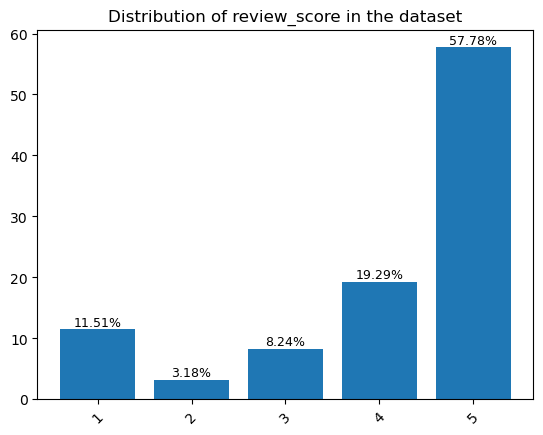

In [48]:
plotDistributionBar(df_order_reviews, 'review_score')

Since the reviews are in Portugese, we will not be using their content for any analysis.

In [49]:
df_order_reviews['review_id'].nunique()

98410

#### Quick findings


- Reviews dataset has information about reviews given by the customers. It consists of review score, comment, review creation date and review submission timestamp.
- We have a total of 99224 review ids of which 98410 are the unique review ids. It means there are 814 reviews which have been resubmitted. These are the ones that need to be tackled.
- We have 98673 unique order ids and 98410 unique review ids. It means that there are 263 reviews with same order id. It is possible that these reviews are for different products ordered under same order id.
- There are no duplicates across rows or columns.
- 57.8 % of the dataset has a review score of 5.

### 5. Products dataset

In [50]:
df_products.shape

(32951, 9)

In [51]:
df_products.sample(5)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
14052,ed506becc3430a3a6331df5b4c3eaed3,fashion_bolsas_e_acessorios,48.0,731.0,1.0,300.0,16.0,2.0,11.0
9651,50a88b3bd7a9d8db2f1addc427b4446b,cama_mesa_banho,56.0,417.0,1.0,2450.0,45.0,15.0,35.0
7186,1473e2c8f813f1f2ec24bd8ff09ff55c,automotivo,59.0,695.0,6.0,1350.0,47.0,19.0,23.0
14247,3150c2690393e7ea7c2b3acf2479ec8c,bebes,51.0,1321.0,4.0,27067.0,37.0,77.0,52.0
10445,b6046194183ce54d8fcaa7a2d28b1095,ferramentas_jardim,60.0,531.0,5.0,400.0,30.0,7.0,23.0


In [52]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


Let's fix the typo in the column names 'lenght' -> 'length'

In [53]:
df_products['product_name_length'] = df_products['product_name_lenght']
df_products['product_description_length'] = df_products['product_description_lenght']
df_products.drop(columns=['product_name_lenght','product_description_lenght'], inplace=True)
df_products.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_photos_qty          32341 non-null  float64
 3   product_weight_g            32949 non-null  float64
 4   product_length_cm           32949 non-null  float64
 5   product_height_cm           32949 non-null  float64
 6   product_width_cm            32949 non-null  float64
 7   product_name_length         32341 non-null  float64
 8   product_description_length  32341 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [54]:
df_products['product_id'].nunique()

32951

In [55]:
df_products['product_category_name'].nunique()

73

In [56]:
df_products.isna().sum().sort_values(ascending=False)

product_category_name         610
product_photos_qty            610
product_name_length           610
product_description_length    610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
product_id                      0
dtype: int64

In [57]:
(df_products.isna().sum() / df_products.shape[0] * 100).sort_values(ascending=False)

product_category_name         1.851234
product_photos_qty            1.851234
product_name_length           1.851234
product_description_length    1.851234
product_weight_g              0.006070
product_length_cm             0.006070
product_height_cm             0.006070
product_width_cm              0.006070
product_id                    0.000000
dtype: float64

#### Quick findings

- Products dataset has information about product categories, and their attributes.
- `product_id` is the primary key of the dataset.
- There are 73 unique product categories.
- `product_category_name` is in Portugese
- 610 products don't have the `product_category_name`, 1.85% of the dataset
- There are few null values and we need to impute these values.

Imputing missing values

- We have seen that the rows which are missing values, a majority are missing a categorical data ie. product category name and respective, description, name length and photo quantities which are numerical.
- We can find out the rows which are exactly matching the columns (weight, lenght, height, width) and we can fill the null value with the product category name of the matching category. We can fill rest of the values ie product description lenght, product name lenght and photo quantity with either mean, median or mode of that known category.
- If there are multiple matches for product category, we can filter out the category with most occuring match.
- If there is no match we can create a separate category 'other' and fill rest of the values with either of mean, median or mode (determined after making a boxplot).
- We will separate the rows from products dataframe with the missing values in separate dataframe (missing) and create another dataframe (all_values) where there is no null values.
- We will find the element wise match of missing with all_values.
- We only have two rows with missing product weight, height, length and width. We will use mean to fill these values.

<Axes: xlabel='product_category_name'>

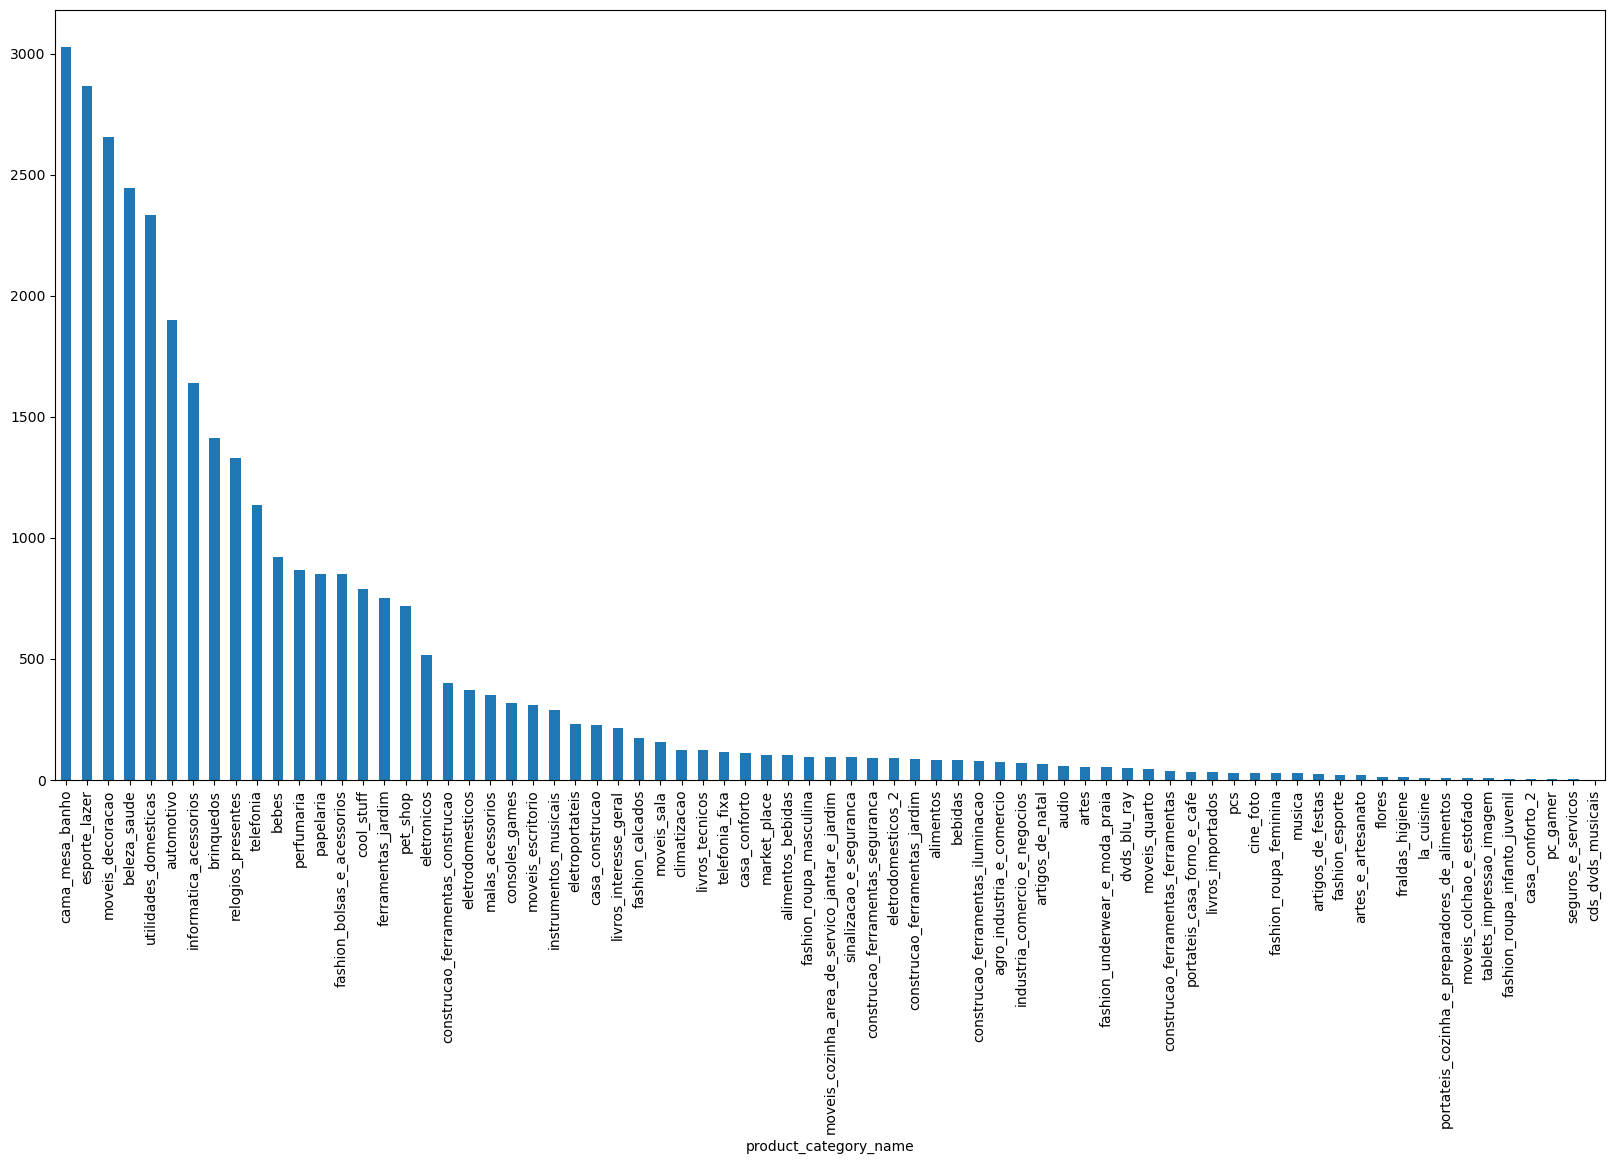

In [58]:
# quickly checking the categories
df_products['product_category_name'].value_counts().plot(kind='bar', figsize=(20, 10),)

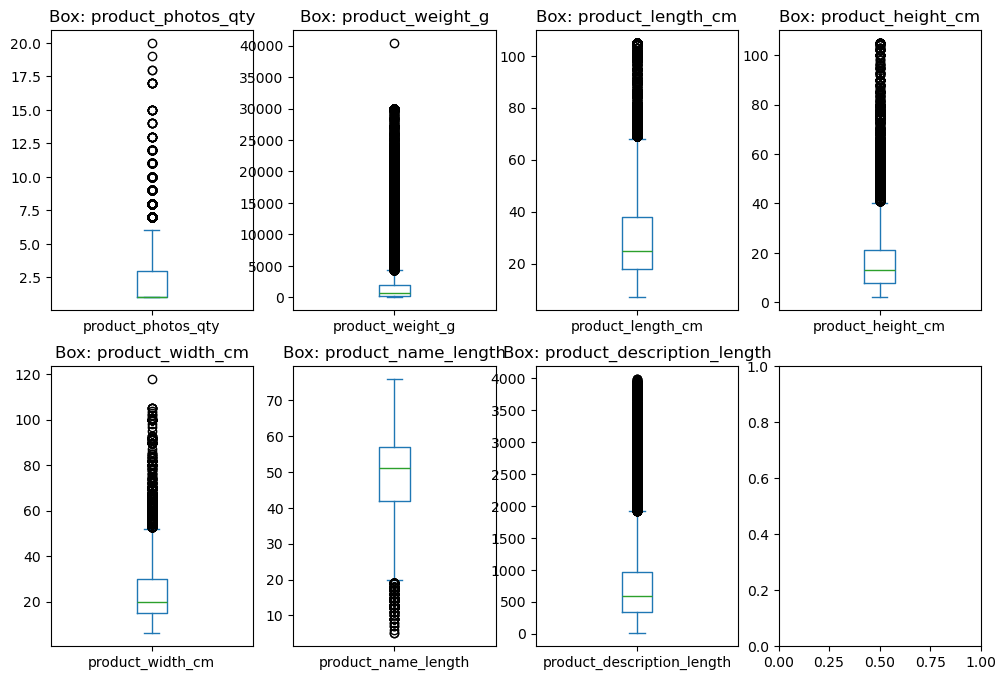

In [59]:
# making box plots for all the numeric columns
fig, axes = plt.subplots(2,4, figsize=(12,8))
numeric = df_products.select_dtypes(include=np.number).columns
for i, val in enumerate(numeric):
    df_products[val].plot.box(title=f'Box: {val}', ax=axes.flat[i])

We can see from the box plot that there are a bunch of outliers in every box plot. We can use median to impute the missing values.

In [60]:
#separating the missing values and known values
missing = df_products[df_products['product_category_name'].isnull()]
all_values = df_products[df_products['product_category_name'].notnull()]

#getting the column names for 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm'
col = missing.columns[5:]
col

Index(['product_height_cm', 'product_width_cm', 'product_name_length',
       'product_description_length'],
      dtype='object')

In [61]:
#checking for match and saving the index and values in a dictionary
match = dict()
for i in missing.index:
    if ((all_values.iloc[:, 5] == missing.loc[i, col[0]]) & (all_values.iloc[:, 6]==missing.loc[i, col[1]]) & (all_values.iloc[:, 7]==missing.loc[i, col[2]]) & (all_values.iloc[:, 8]==missing.loc[i, col[3]])).sum()>0:
        #saving the product category which is most occuring
        match[i]=all_values[(all_values.iloc[:, 5]==missing.loc[i, col[0]]) & (all_values.iloc[:, 6]==missing.loc[i, col[1]]) & (all_values.iloc[:, 7]==missing.loc[i, col[2]]) & (all_values.iloc[:, 8]==missing.loc[i, col[3]])]['product_category_name'].value_counts().head(1).index
    else:
        match[i]='empty'

In [62]:
#imputing the missing values
for i in match.keys():
    if match[i]!='empty':
        #where there is a match we are filling the value with median of columns for the category we are assigning
        df_products.loc[i, 'product_category_name']=match[i][0]
        df_products.loc[i, 'product_name_length']=round(df_products[df_products['product_category_name']== match[i][0]]['product_name_length'].median())
        df_products.loc[i, 'product_description_length']=round(df_products[df_products['product_category_name']== match[i][0]]['product_description_length'].median())
        df_products.loc[i, 'product_photos_qty']=round(df_products[df_products['product_category_name']== match[i][0]]['product_photos_qty'].median())
    else:
        #for no match we are filling with other
        df_products.loc[i, 'product_category_name']='Other'
        df_products.loc[i, 'product_name_length']=round(df_products['product_name_length'].median())
        df_products.loc[i, 'product_description_length']=round(df_products['product_description_length'].median())
        df_products.loc[i, 'product_photos_qty']=round(df_products['product_photos_qty'].median())

df_products['product_weight_g']=df_products['product_weight_g'].fillna(round(df_products['product_weight_g'].mean()))
df_products['product_length_cm']=df_products['product_length_cm'].fillna(round(df_products['product_length_cm'].mean()))
df_products['product_height_cm']=df_products['product_height_cm'].fillna(round(df_products['product_height_cm'].mean()))
df_products['product_width_cm']=df_products['product_width_cm'].fillna(round(df_products['product_width_cm'].mean()))

In [63]:
df_products.isna().sum()

product_id                    0
product_category_name         0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
product_name_length           0
product_description_length    0
dtype: int64

### 6. Sellers dataset

In [64]:
df_sellers.shape

(3095, 4)

In [65]:
df_sellers.sample(5)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
1754,60da8bfa7eebe230b7d66ac4082d79b3,15940,fernando prestes,SP
1681,a89e143d5211473ae18db9577ee34b64,13486,limeira,SP
2456,4c4d546adf3c3868fe19c9ec6e9ffda9,87013,maringa,PR
588,87d3c3aeb3ead335511b3ce315eb341e,3059,sao paulo,SP
1363,7cb946b1ad19faebe28c3e86c2794ec3,35701,sete lagoas,MG


In [66]:
df_sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [67]:
df_sellers['seller_id'].nunique()

3095

In [68]:
df_sellers.isna().sum()

seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

In [69]:
df_sellers.duplicated().sum()

0

In [70]:
df_sellers.columns.has_duplicates

False

In [71]:
df_sellers['seller_state'].nunique()

23

In [72]:
df_sellers['seller_city'].nunique()

611

<Figure size 640x480 with 0 Axes>

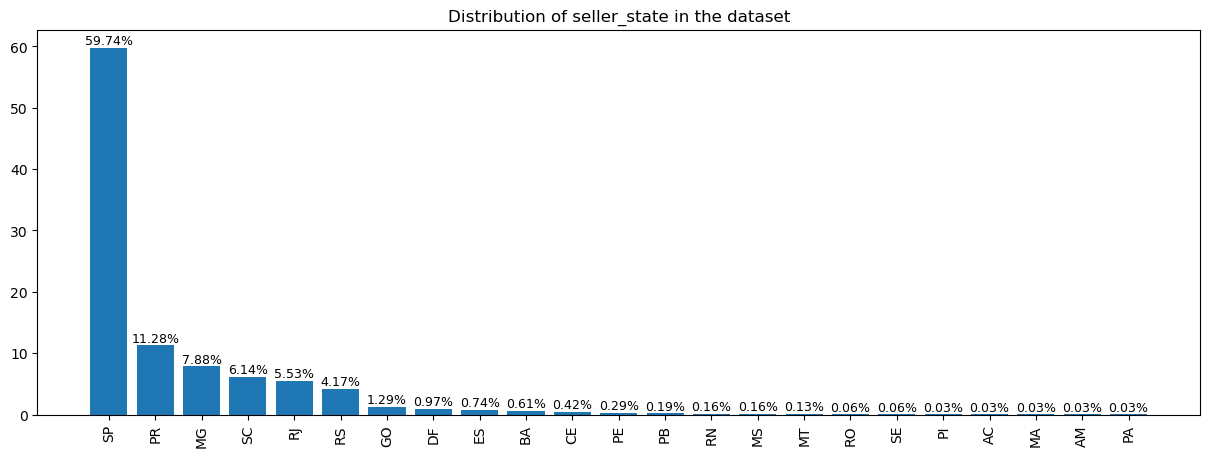

In [73]:
plotDistributionBar(df_sellers, 'seller_state')

#### Quick findings:

- `seller_id` is the primary key, with 3095 unique values
- There are no null values
- There are no duplicates
- Sellers are from 23 states. Brazil has 26 states in all.
- About 60 percent of the sellers are from the south eastern state of Sao Paulo. A Google search shows that Sao Paulo is the most populous state in Brazil, accounting for about 21.8 percent of the country's population. It is also the richest state in Brazil, contributing to 33.9%  of the country's GDP.

### 7. Customers dataset

In [74]:
df_customers.shape

(99441, 5)

In [75]:
df_customers.sample(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
98803,97923f8039a8e507b87d33d7f77f2f55,3dbf5550a66b1e9172706dfa48e2b2ef,9785,sao bernardo do campo,SP
42937,8fe93bf674e747a279720f0f88013776,e49c5a8e64db199592cb23a9f50e9e95,6182,osasco,SP
53719,f5e85d85dbeb2debc1f3823cfce633c1,de1b7bc73693b558e505ad4099639843,16600,pirajui,SP
60929,d866f14443d6d667b9cbed78b30d4799,f8426a7e573a60f20f4331e8b8832f72,82630,curitiba,PR
53768,3f5d98eee5439942b85e0098843bc4cc,bbbc7054c34b03503b905cbea71f2684,73355,brasilia,DF


In [76]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [77]:
df_customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [78]:
df_customers.duplicated().sum()

0

In [79]:
df_customers.columns.has_duplicates

False

In [80]:
df_customers['customer_id'].nunique()

99441

In [81]:
df_customers['customer_unique_id'].nunique()

96096

In [82]:
99441 - 96096

3345

In [83]:
#percentage of repeat customers
96096/99441

0.9663619633752677

There are some repeat customers, but most are new.

In [84]:
df_customers['customer_state'].nunique()

27

<Figure size 640x480 with 0 Axes>

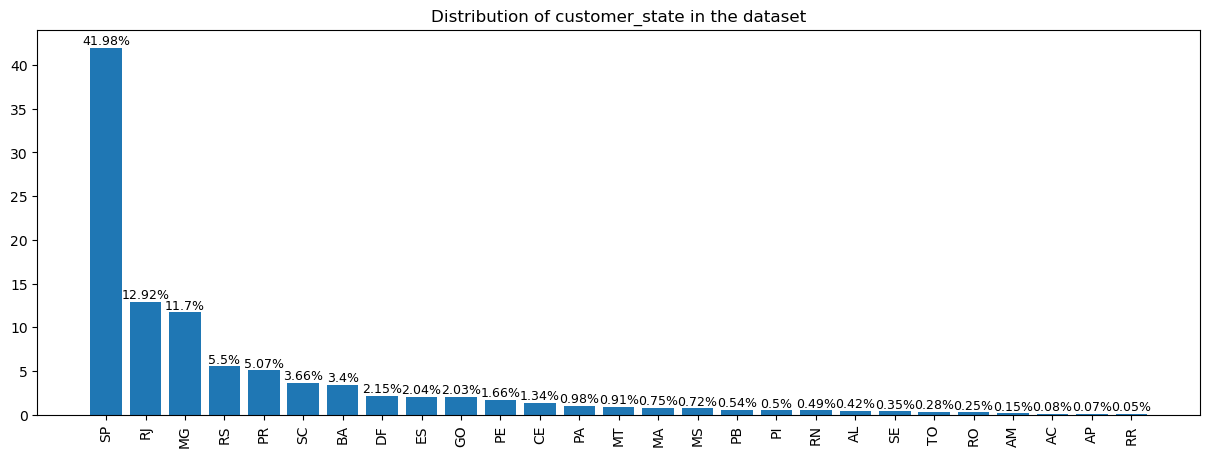

In [85]:
plotDistributionBar(df_customers, 'customer_state')

#### Quick findings:

- `customer_id` is the primary key for this dataset.
- We have a total of 96096 unique customer ids. It shows that we have around 96.6 % of new customers. Only 3.4% of the customers have made repeat purchase from the olist platform. It is because olist was founded in 2015 and they started selling online in 2016. The data we downloaded from Kaggel is from 2016 to 2018, when it was fairly new thus we only have new customers.
- There are no duplicates across rows or columns.
- There is no null value.
- Sao Paulo has the largest percentage of customers.

### 8. Product category name translation dataset

In [86]:
df_name_translation.shape

(71, 2)

In [87]:
df_name_translation.sample(5)

,product_category_name,product_category_name_english
57,livros_importados,books_imported
59,cine_foto,cine_photo
13,tablets_impressao_imagem,tablets_printing_image
24,climatizacao,air_conditioning
64,cds_dvds_musicais,cds_dvds_musicals


In [88]:
df_name_translation.isna().sum()

product_category_name            0
product_category_name_english    0
dtype: int64

In [89]:
df_name_translation.duplicated().sum()

0

There were 73 unique values of product_category names in the products dataset, and here we have only 71 unique values. Let's try to find out which categories are missing their english translation.

In [90]:
missing_translations = set(df_products['product_category_name']) - set(df_name_translation['product_category_name'])
missing_translations

{'Other', 'pc_gamer', 'portateis_cozinha_e_preparadores_de_alimentos'}

In [91]:
df_products.loc[df_products['product_category_name'] == 'pc_gamer'].value_counts().sum()

3

In [92]:
df_products.loc[df_products['product_category_name'] == 'portateis_cozinha_e_preparadores_de_alimentos'].value_counts().sum()

10

Add the 2 categories with their translation to the table

In [93]:
df_name_translation.loc[len(df_name_translation.index)] = ['pc_gamer', 'pc_gamer']
df_name_translation.loc[len(df_name_translation.index)] = ['portateis_cozinha_e_preparadores_de_alimentos', 'portable_kitchen_gadgets']
df_name_translation.loc[len(df_name_translation.index)] = ['Other', 'other']

In [94]:
df_name_translation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74 entries, 0 to 73
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          74 non-null     object
 1   product_category_name_english  74 non-null     object
dtypes: object(2)
memory usage: 1.7+ KB


### 9. Geolocation dataset

In [95]:
df_geolocation.shape

(1000163, 5)

In [96]:
df_geolocation.sample(5)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
753354,64218,-2.906396,-41.782192,parnaíba,PI
239062,9890,-23.697671,-46.569702,sao bernardo do campo,SP
734165,58950,-7.212448,-38.586460,monte horebe,PB
577592,32900,-20.070944,-44.306550,igarape,MG
15,1046,-23.546081,-46.644820,sao paulo,SP


In [97]:
df_geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [98]:
df_geolocation.isna().sum()

geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

In [99]:
df_geolocation.duplicated().sum()

261831

There are many duplicates here, we can drop that, keeping only the first of the matching row.

In [100]:
df_geolocation.drop_duplicates(keep='first', inplace=True)

In [101]:
#checking duplicates across rows
df_geolocation.duplicated().sum()

0

#### Quick findings

- We will not be using the geolocation dataset for further analysis. We have the state and city for the sellers and customers and that is enough for us.

## Merging the dataset

**Merging product_category_translation with products**

Joining the product category with english names of the products and dropping the original product category name with names in Portugese.

In [102]:
print(df_products.shape)
print(df_name_translation.shape)
df_products_final = pd.merge(left=df_products, right=df_name_translation, on='product_category_name', how='left')
print(df_products_final.shape)

(32951, 9)
(74, 2)
(32951, 10)


In [103]:
df_products_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     32951 non-null  object 
 1   product_category_name          32951 non-null  object 
 2   product_photos_qty             32951 non-null  float64
 3   product_weight_g               32951 non-null  float64
 4   product_length_cm              32951 non-null  float64
 5   product_height_cm              32951 non-null  float64
 6   product_width_cm               32951 non-null  float64
 7   product_name_length            32951 non-null  float64
 8   product_description_length     32951 non-null  float64
 9   product_category_name_english  32951 non-null  object 
dtypes: float64(7), object(3)
memory usage: 2.5+ MB


In [104]:
# drop columns that are not relevant to our analysis
df_products_final.drop(columns=['product_category_name', 'product_photos_qty', 'product_name_length', 'product_description_length'], inplace=True)

# confirm that columns were dropped
df_products_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     32951 non-null  object 
 1   product_weight_g               32951 non-null  float64
 2   product_length_cm              32951 non-null  float64
 3   product_height_cm              32951 non-null  float64
 4   product_width_cm               32951 non-null  float64
 5   product_category_name_english  32951 non-null  object 
dtypes: float64(4), object(2)
memory usage: 1.5+ MB


In [105]:
df_products_final.isna().sum()

product_id                       0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
product_category_name_english    0
dtype: int64

In [106]:
# Saving the final dataset to csv
df_products_final.to_csv('../data/interim/products_final_dataset.csv', index=False)

We will be joining the tables to get a master table for figuring out the sales performance.

Starting from the orders dataset, we will first join the order_items and then the products dataset.

**Merging Orders and Order_items**

In [107]:
print(df_orders.shape)
print(df_order_items.shape)
df_orders_final = pd.merge(left=df_orders, right= df_order_items, on= 'order_id', how='inner')
print(df_orders_final.shape)

(99441, 8)
(112650, 7)
(112650, 14)


In [108]:
df_orders_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   customer_id                    112650 non-null  object        
 2   order_status                   112650 non-null  object        
 3   order_purchase_timestamp       112650 non-null  datetime64[ns]
 4   order_approved_at              112635 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111456 non-null  datetime64[ns]
 6   order_delivered_customer_date  110196 non-null  datetime64[ns]
 7   order_estimated_delivery_date  112650 non-null  datetime64[ns]
 8   order_item_id                  112650 non-null  int64         
 9   product_id                     112650 non-null  object        
 10  seller_id                      112650 non-null  object        
 11  

In [109]:
df_orders_final.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
dtype: int64

Next we will join the products table.

**Merging Products table with Order_final**

In [110]:
print(df_orders_final.shape)
print(df_products_final.shape)
df_order_prod = pd.merge(left=df_orders_final, right=df_products_final, on='product_id', how='inner')
print(df_order_prod.shape)

(112650, 14)
(32951, 6)
(112650, 19)


In [111]:
df_order_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   customer_id                    112650 non-null  object        
 2   order_status                   112650 non-null  object        
 3   order_purchase_timestamp       112650 non-null  datetime64[ns]
 4   order_approved_at              112635 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111456 non-null  datetime64[ns]
 6   order_delivered_customer_date  110196 non-null  datetime64[ns]
 7   order_estimated_delivery_date  112650 non-null  datetime64[ns]
 8   order_item_id                  112650 non-null  int64         
 9   product_id                     112650 non-null  object        
 10  seller_id                      112650 non-null  object        
 11  

In [112]:
df_order_prod.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
product_weight_g                    0
product_length_cm                   0
product_height_cm                   0
product_width_cm                    0
product_category_name_english       0
dtype: int64

**Merging Sellers datset with the df_order_prod**

In [113]:
print(df_order_prod.shape)
print(df_sellers.shape)
df_order_prod_seller = pd.merge(left=df_order_prod, right=df_sellers, on='seller_id', how='left')
print(df_order_prod_seller.shape)

(112650, 19)
(3095, 4)
(112650, 22)


In [114]:
df_order_prod_seller.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   customer_id                    112650 non-null  object        
 2   order_status                   112650 non-null  object        
 3   order_purchase_timestamp       112650 non-null  datetime64[ns]
 4   order_approved_at              112635 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111456 non-null  datetime64[ns]
 6   order_delivered_customer_date  110196 non-null  datetime64[ns]
 7   order_estimated_delivery_date  112650 non-null  datetime64[ns]
 8   order_item_id                  112650 non-null  int64         
 9   product_id                     112650 non-null  object        
 10  seller_id                      112650 non-null  object        
 11  

In [115]:
df_order_prod_seller.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
product_weight_g                    0
product_length_cm                   0
product_height_cm                   0
product_width_cm                    0
product_category_name_english       0
seller_zip_code_prefix              0
seller_city                         0
seller_state                        0
dtype: int64

**Merging Customer dataset**

In [116]:
print(df_order_prod_seller.shape)
print(df_customers.shape)
df_orders_with_cust = pd.merge(left=df_order_prod_seller, right=df_customers, on='customer_id', how='left')
print(df_orders_with_cust.shape)

(112650, 22)
(99441, 5)
(112650, 26)


In [117]:
df_orders_with_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   customer_id                    112650 non-null  object        
 2   order_status                   112650 non-null  object        
 3   order_purchase_timestamp       112650 non-null  datetime64[ns]
 4   order_approved_at              112635 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111456 non-null  datetime64[ns]
 6   order_delivered_customer_date  110196 non-null  datetime64[ns]
 7   order_estimated_delivery_date  112650 non-null  datetime64[ns]
 8   order_item_id                  112650 non-null  int64         
 9   product_id                     112650 non-null  object        
 10  seller_id                      112650 non-null  object        
 11  

In [118]:
df_orders_with_cust.isna().sum().sort_values(ascending=False)

order_delivered_customer_date    2454
order_delivered_carrier_date     1194
order_approved_at                  15
order_id                            0
product_length_cm                   0
customer_city                       0
customer_zip_code_prefix            0
customer_unique_id                  0
seller_state                        0
seller_city                         0
seller_zip_code_prefix              0
product_category_name_english       0
product_width_cm                    0
product_height_cm                   0
freight_value                       0
product_weight_g                    0
customer_id                         0
price                               0
shipping_limit_date                 0
seller_id                           0
product_id                          0
order_item_id                       0
order_estimated_delivery_date       0
order_purchase_timestamp            0
order_status                        0
customer_state                      0
dtype: int64

**Merging the Reviews dataset**

In [119]:
print(df_orders_with_cust.shape)
print(df_order_reviews.shape)
df_olist_merged = pd.merge(left=df_orders_with_cust, right=df_order_reviews, on='order_id', how='inner')
print(df_olist_merged.shape)

(112650, 26)
(99224, 7)
(112372, 32)


In [120]:
df_olist_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112372 entries, 0 to 112371
Data columns (total 32 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112372 non-null  object        
 1   customer_id                    112372 non-null  object        
 2   order_status                   112372 non-null  object        
 3   order_purchase_timestamp       112372 non-null  datetime64[ns]
 4   order_approved_at              112357 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111188 non-null  datetime64[ns]
 6   order_delivered_customer_date  110012 non-null  datetime64[ns]
 7   order_estimated_delivery_date  112372 non-null  datetime64[ns]
 8   order_item_id                  112372 non-null  int64         
 9   product_id                     112372 non-null  object        
 10  seller_id                      112372 non-null  object        
 11  

In [121]:
df_olist_merged.isna().sum().sort_values(ascending=False)

review_comment_title             98938
review_comment_message           64730
order_delivered_customer_date     2360
order_delivered_carrier_date      1184
order_approved_at                   15
order_id                             0
customer_city                        0
seller_city                          0
seller_state                         0
customer_unique_id                   0
customer_zip_code_prefix             0
review_score                         0
customer_state                       0
review_id                            0
product_category_name_english        0
review_creation_date                 0
seller_zip_code_prefix               0
product_height_cm                    0
product_width_cm                     0
customer_id                          0
product_length_cm                    0
product_weight_g                     0
freight_value                        0
price                                0
shipping_limit_date                  0
seller_id                

**There are some columns that are not relevant to our questions, before we start dropping columns, let's save this merged dataframe.**

In [122]:
df_olist_merged.to_csv("../data/interim/olist_merged.csv")

### Dropping irrelevant columns

- `review_comment_title` and `review_comment_message` are in Portugese and we cannot do any analysis on them sicne we don't know Portugese. We will drop them.
- We only care about the `review_score` so we will drop `review_answer_timestamp`, `review_id`, `review_creation_date`
- We have the customer and seller's state and city, so we will drop the zip code prefixes - `seller_zip_code_prefix`, `customer_zip_code_prefix`
- We don't care about `order_approved_at` as we are looking at the `order_status` for our analysis.
- We will also drop `customer_unique_id` because over 96% of the dataset has new customers only.

In [123]:
df_olist_final = df_olist_merged.drop(columns=['review_comment_title',
                                               'review_comment_message',
                                               'review_answer_timestamp',
                                               'review_id',
                                               'review_creation_date',
                                               'seller_zip_code_prefix',
                                               'customer_zip_code_prefix',
                                               'order_approved_at',
                                               'customer_unique_id'])

Let's confirm that the columns were dropped.

In [124]:
df_olist_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112372 entries, 0 to 112371
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112372 non-null  object        
 1   customer_id                    112372 non-null  object        
 2   order_status                   112372 non-null  object        
 3   order_purchase_timestamp       112372 non-null  datetime64[ns]
 4   order_delivered_carrier_date   111188 non-null  datetime64[ns]
 5   order_delivered_customer_date  110012 non-null  datetime64[ns]
 6   order_estimated_delivery_date  112372 non-null  datetime64[ns]
 7   order_item_id                  112372 non-null  int64         
 8   product_id                     112372 non-null  object        
 9   seller_id                      112372 non-null  object        
 10  shipping_limit_date            112372 non-null  datetime64[ns]
 11  

Renaming the order_item_id as 'quantity' as it tells us about the number of items bought

In [125]:
# rename the order_item_id to qty as it hold the quantity of items in each category.
df_olist_final.rename(columns = {'order_item_id':'quantity' }, inplace = True)

In [126]:
df_olist_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112372 entries, 0 to 112371
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112372 non-null  object        
 1   customer_id                    112372 non-null  object        
 2   order_status                   112372 non-null  object        
 3   order_purchase_timestamp       112372 non-null  datetime64[ns]
 4   order_delivered_carrier_date   111188 non-null  datetime64[ns]
 5   order_delivered_customer_date  110012 non-null  datetime64[ns]
 6   order_estimated_delivery_date  112372 non-null  datetime64[ns]
 7   quantity                       112372 non-null  int64         
 8   product_id                     112372 non-null  object        
 9   seller_id                      112372 non-null  object        
 10  shipping_limit_date            112372 non-null  datetime64[ns]
 11  

In [127]:
df_olist_final.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_delivered_carrier_date     1184
order_delivered_customer_date    2360
order_estimated_delivery_date       0
quantity                            0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
product_weight_g                    0
product_length_cm                   0
product_height_cm                   0
product_width_cm                    0
product_category_name_english       0
seller_city                         0
seller_state                        0
customer_city                       0
customer_state                      0
review_score                        0
dtype: int64

In [128]:
df_olist_final.loc[df_olist_final['order_status'] == 'delivered'].isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_delivered_carrier_date     2
order_delivered_customer_date    8
order_estimated_delivery_date    0
quantity                         0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
product_category_name_english    0
seller_city                      0
seller_state                     0
customer_city                    0
customer_state                   0
review_score                     0
dtype: int64

- For all the cases where order status is not 'delivered', a null value for order_delivered_carrier_date and order_delivered_customer_date actually makes sense.
- There are 8 rows where the status is delivered but the `order_delivered_customer_date` is null, should I impute this or drop the rows?
- There are 2 rows where the status is delivered but the `order_delivered_carrier_date` is null, these can be deleted.

### Saving the cleaned and combined dataset

The merged dataset is good enough for our visualization purposes I think. Let's save it and give it a whirl in Tableau.

In [129]:
df_olist_final.to_csv("../data/final/olist_final.csv")